In [48]:
# Basic imports, make sure they can import robustness
import torch as ch
from robustness.datasets import DATASETS
from robustness.tools.vis_tools import show_image_row
from robustness.tools import helpers
from robustness import model_utils, datasets
from torchvision.models import *
import torchvision.transforms as transforms
from robustness.tools.label_maps import CLASS_DICT

from tqdm import tqdm
import numpy as np
import PIL

%matplotlib inline

In [2]:
BATCH_SIZE = 5
NUM_WORKERS = 10

In [3]:
imagenet_ds = DATASETS['imagenet']('/scratch/engstrom_scratch/imagenet')
_, in_loader = imagenet_ds.make_loaders(NUM_WORKERS, BATCH_SIZE)
normalization_function = helpers.InputNormalize(imagenet_ds.mean, imagenet_ds.std)

==> Preparing dataset imagenet..


In [4]:
def load_model(arch, dataset=None):
    if arch != 'robust':
        model = eval(arch)(pretrained=True).cuda()
        model.eval()
        model = ch.nn.DataParallel(model)
        pass
    else:
        model_kwargs = {
            'arch': 'resnet50',
            'dataset': dataset,
            'resume_path': f'./models/RestrictedImageNet.pt'
        }

        model, _ = model_utils.make_and_restore_model(**model_kwargs)
        model.eval()
        model = model.module
    return model

model = load_model('resnet18')

In [5]:
def forward_pass(mod, im):
    im_norm = normalization_function(im)
    op = mod(im_norm.cuda())
    if len(op) == 2:
        return op[0]
    else:
        return op

In [6]:
if False: # Use only if dataloader is complete imagenet
    correct_cnt, total = 0, 0
    it = tqdm(enumerate(in_loader), total=len(in_loader))
    for itidx, (im, targ) in it:
        with ch.no_grad():
            op = forward_pass(model, im)
            pred = op.argmax(dim=1)
            correct = targ.cuda().eq(pred)

            correct_cnt += np.sum(correct.cpu().numpy())
            total += len(targ)
            it.set_description(f"Accuracy: {100 * correct_cnt/total:.2f}%")

In [96]:
def class_loss_wrapper(targ_class, maximize=1):
    
    def class_loss(op, targ):
        loss = maximize * ch.mean(op[:, targ_class])
        print(loss)
        return loss
    
    return class_loss

def get_gradient(mod, im, targ, custom_loss=None):
    if custom_loss is None:
        loss_fn = ch.nn.CrossEntropyLoss()
    else:
        loss_fn = custom_loss 
        
    x = im.clone().detach().requires_grad_(True)
    op = forward_pass(mod, x)
    loss = loss_fn(op, targ.cuda())
    grad, = ch.autograd.grad(loss, [x])
    return grad

def vis_tensor(t):
    mt = ch.mean(t, dim=[2, 3], keepdim=True).expand_as(t)
    st = ch.std(t, dim=[2, 3], keepdim=True).expand_as(t)
    return ch.clamp((t - mt) / (4 * st) + 0.5, 0, 1) 

def smooth_grad(mod, im, targ, Nsamples, stdev, custom_loss=None):
    total_gradients = 0
    it = tqdm(enumerate(range(Nsamples)), total=Nsamples)
    for _, n in it:
        noise = ch.tensor(np.random.normal(0, stdev, im.shape), dtype=im.dtype)
        noised_im = im + noise
        grad = get_gradient(mod, noised_im, targ, custom_loss=custom_loss)
        total_gradients += grad

    return total_gradients / Nsamples

In [8]:
_, (img, targ) = next(enumerate(in_loader))

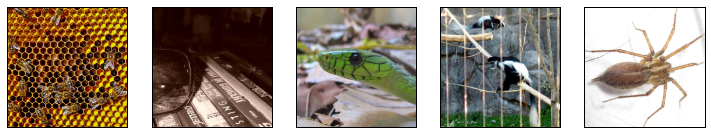

In [9]:
show_image_row([img[:10]])

In [10]:
grad = get_gradient(model, img, targ)
sgrad = smooth_grad(model, img, targ, 10, 0.3)

100%|██████████| 10/10 [00:01<00:00,  8.95it/s]


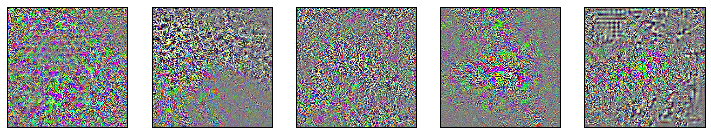

In [11]:
show_image_row([vis_tensor(grad)])

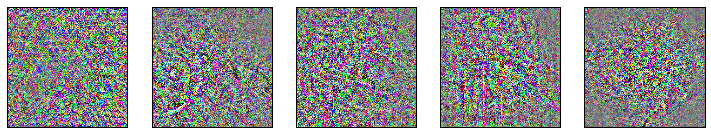

In [12]:
show_image_row([vis_tensor(sgrad)])

## Gradients of a robust model

In [49]:
restricted_imagenet_ds = datasets.RestrictedImageNet('/scratch/engstrom_scratch/imagenet')
_, rin_loader = restricted_imagenet_ds.make_loaders(workers=NUM_WORKERS, 
                                                          batch_size=BATCH_SIZE, 
                                                          data_aug=False)

CD = CLASS_DICT['RestrictedImageNet']

==> Preparing dataset restricted_imagenet..


In [14]:
robust_model = load_model('robust', restricted_imagenet_ds)

=> loading checkpoint './models/RestrictedImageNet.pt'
=> loaded checkpoint './models/RestrictedImageNet.pt' (epoch 61)


In [36]:
_, (img, targ) = next(enumerate(rin_loader))

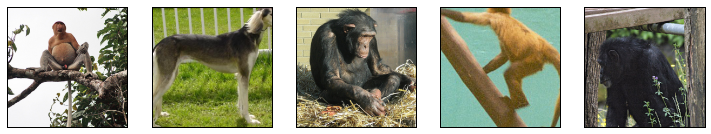

In [37]:
show_image_row([img])

In [59]:
grad_loss = get_gradient(robust_model, img, targ)

targ_class = 1
print(CD[3])
class_loss = class_loss_wrapper(3)
grad_class = get_gradient(robust_model, img, targ, custom_loss=class_loss) 

turtle


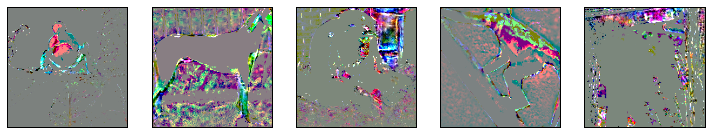

In [60]:
show_image_row([vis_tensor(grad)])

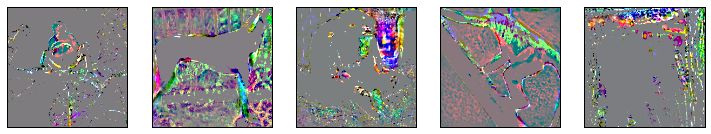

In [61]:
show_image_row([vis_tensor(grad_class)])

In [97]:
def take_gradient_steps(mod, im, targ, step_size, Nsteps, 
                        custom_loss=None, normalize=True):
    it = tqdm(enumerate(range(Nsteps)), total=Nsteps)
    x = im.clone()
    
    for _, i in it:    
        g = get_gradient(mod, x, targ, custom_loss=custom_loss)
        if normalize:
            g = g.renorm(p=2, dim=0, maxnorm=100)
        x = ch.clamp(x + step_size * g, 0, 1)
    return x

In [98]:
class_loss = class_loss_wrapper(3, maximize=-1)


im_new = take_gradient_steps(robust_model, img, targ, 0.1, 300, 
                             custom_loss=class_loss, normalize=True)


  0%|          | 1/300 [00:00<04:31,  1.10it/s]

tensor(2.1899, device='cuda:0', grad_fn=<MulBackward0>)
tensor(2.2016, device='cuda:0', grad_fn=<MulBackward0>)
tensor(2.2132, device='cuda:0', grad_fn=<MulBackward0>)



  2%|▏         | 5/300 [00:01<02:25,  2.02it/s]

tensor(2.2248, device='cuda:0', grad_fn=<MulBackward0>)
tensor(2.2364, device='cuda:0', grad_fn=<MulBackward0>)
tensor(2.2481, device='cuda:0', grad_fn=<MulBackward0>)



  3%|▎         | 9/300 [00:01<01:19,  3.66it/s]

tensor(2.2596, device='cuda:0', grad_fn=<MulBackward0>)
tensor(2.2710, device='cuda:0', grad_fn=<MulBackward0>)
tensor(2.2821, device='cuda:0', grad_fn=<MulBackward0>)
tensor(2.2930, device='cuda:0', grad_fn=<MulBackward0>)



  4%|▍         | 13/300 [00:01<00:47,  6.02it/s]

tensor(2.3036, device='cuda:0', grad_fn=<MulBackward0>)
tensor(2.3142, device='cuda:0', grad_fn=<MulBackward0>)
tensor(2.3248, device='cuda:0', grad_fn=<MulBackward0>)
tensor(2.3353, device='cuda:0', grad_fn=<MulBackward0>)



  6%|▌         | 17/300 [00:02<00:32,  8.78it/s]

tensor(2.3457, device='cuda:0', grad_fn=<MulBackward0>)
tensor(2.3560, device='cuda:0', grad_fn=<MulBackward0>)
tensor(2.3664, device='cuda:0', grad_fn=<MulBackward0>)
tensor(2.3768, device='cuda:0', grad_fn=<MulBackward0>)



  7%|▋         | 21/300 [00:02<00:24, 11.20it/s]

tensor(2.3872, device='cuda:0', grad_fn=<MulBackward0>)
tensor(2.3974, device='cuda:0', grad_fn=<MulBackward0>)
tensor(2.4075, device='cuda:0', grad_fn=<MulBackward0>)
tensor(2.4177, device='cuda:0', grad_fn=<MulBackward0>)



  8%|▊         | 25/300 [00:02<00:21, 12.68it/s]

tensor(2.4277, device='cuda:0', grad_fn=<MulBackward0>)
tensor(2.4377, device='cuda:0', grad_fn=<MulBackward0>)
tensor(2.4477, device='cuda:0', grad_fn=<MulBackward0>)



  9%|▉         | 27/300 [00:02<00:19, 13.89it/s]

tensor(2.4577, device='cuda:0', grad_fn=<MulBackward0>)
tensor(2.4676, device='cuda:0', grad_fn=<MulBackward0>)
tensor(2.4775, device='cuda:0', grad_fn=<MulBackward0>)
tensor(2.4875, device='cuda:0', grad_fn=<MulBackward0>)



 10%|█         | 31/300 [00:02<00:17, 15.27it/s]

tensor(2.4974, device='cuda:0', grad_fn=<MulBackward0>)
tensor(2.5071, device='cuda:0', grad_fn=<MulBackward0>)
tensor(2.5169, device='cuda:0', grad_fn=<MulBackward0>)
tensor(2.5265, device='cuda:0', grad_fn=<MulBackward0>)



 12%|█▏        | 35/300 [00:03<00:16, 16.23it/s]

tensor(2.5361, device='cuda:0', grad_fn=<MulBackward0>)
tensor(2.5457, device='cuda:0', grad_fn=<MulBackward0>)
tensor(2.5552, device='cuda:0', grad_fn=<MulBackward0>)



 12%|█▏        | 37/300 [00:03<00:17, 14.92it/s]

tensor(2.5646, device='cuda:0', grad_fn=<MulBackward0>)
tensor(2.5740, device='cuda:0', grad_fn=<MulBackward0>)
tensor(2.5835, device='cuda:0', grad_fn=<MulBackward0>)



 14%|█▎        | 41/300 [00:03<00:17, 14.75it/s]

tensor(2.5929, device='cuda:0', grad_fn=<MulBackward0>)
tensor(2.6023, device='cuda:0', grad_fn=<MulBackward0>)
tensor(2.6115, device='cuda:0', grad_fn=<MulBackward0>)
tensor(2.6208, device='cuda:0', grad_fn=<MulBackward0>)



 15%|█▌        | 45/300 [00:03<00:16, 15.69it/s]

tensor(2.6301, device='cuda:0', grad_fn=<MulBackward0>)
tensor(2.6393, device='cuda:0', grad_fn=<MulBackward0>)
tensor(2.6484, device='cuda:0', grad_fn=<MulBackward0>)
tensor(2.6576, device='cuda:0', grad_fn=<MulBackward0>)



 16%|█▋        | 49/300 [00:04<00:15, 16.65it/s]

tensor(2.6666, device='cuda:0', grad_fn=<MulBackward0>)
tensor(2.6757, device='cuda:0', grad_fn=<MulBackward0>)
tensor(2.6846, device='cuda:0', grad_fn=<MulBackward0>)
tensor(2.6935, device='cuda:0', grad_fn=<MulBackward0>)



 18%|█▊        | 53/300 [00:04<00:14, 17.11it/s]

tensor(2.7025, device='cuda:0', grad_fn=<MulBackward0>)
tensor(2.7115, device='cuda:0', grad_fn=<MulBackward0>)
tensor(2.7204, device='cuda:0', grad_fn=<MulBackward0>)
tensor(2.7292, device='cuda:0', grad_fn=<MulBackward0>)



 19%|█▉        | 57/300 [00:04<00:14, 16.76it/s]

tensor(2.7380, device='cuda:0', grad_fn=<MulBackward0>)
tensor(2.7468, device='cuda:0', grad_fn=<MulBackward0>)
tensor(2.7556, device='cuda:0', grad_fn=<MulBackward0>)



 20%|██        | 61/300 [00:04<00:14, 16.12it/s]

tensor(2.7644, device='cuda:0', grad_fn=<MulBackward0>)
tensor(2.7732, device='cuda:0', grad_fn=<MulBackward0>)
tensor(2.7819, device='cuda:0', grad_fn=<MulBackward0>)
tensor(2.7906, device='cuda:0', grad_fn=<MulBackward0>)



 22%|██▏       | 65/300 [00:05<00:14, 16.11it/s]

tensor(2.7992, device='cuda:0', grad_fn=<MulBackward0>)
tensor(2.8077, device='cuda:0', grad_fn=<MulBackward0>)
tensor(2.8163, device='cuda:0', grad_fn=<MulBackward0>)
tensor(2.8248, device='cuda:0', grad_fn=<MulBackward0>)



 23%|██▎       | 69/300 [00:05<00:14, 16.17it/s]

tensor(2.8334, device='cuda:0', grad_fn=<MulBackward0>)
tensor(2.8419, device='cuda:0', grad_fn=<MulBackward0>)
tensor(2.8504, device='cuda:0', grad_fn=<MulBackward0>)
tensor(2.8589, device='cuda:0', grad_fn=<MulBackward0>)



 24%|██▍       | 73/300 [00:05<00:14, 15.90it/s]

tensor(2.8673, device='cuda:0', grad_fn=<MulBackward0>)
tensor(2.8756, device='cuda:0', grad_fn=<MulBackward0>)
tensor(2.8839, device='cuda:0', grad_fn=<MulBackward0>)
tensor(2.8920, device='cuda:0', grad_fn=<MulBackward0>)



 25%|██▌       | 75/300 [00:05<00:14, 15.35it/s]

tensor(2.9002, device='cuda:0', grad_fn=<MulBackward0>)
tensor(2.9084, device='cuda:0', grad_fn=<MulBackward0>)
tensor(2.9165, device='cuda:0', grad_fn=<MulBackward0>)



 26%|██▋       | 79/300 [00:06<00:18, 11.72it/s]

tensor(2.9246, device='cuda:0', grad_fn=<MulBackward0>)
tensor(2.9326, device='cuda:0', grad_fn=<MulBackward0>)



 27%|██▋       | 81/300 [00:06<00:18, 11.97it/s]

tensor(2.9407, device='cuda:0', grad_fn=<MulBackward0>)
tensor(2.9487, device='cuda:0', grad_fn=<MulBackward0>)
tensor(2.9569, device='cuda:0', grad_fn=<MulBackward0>)



 28%|██▊       | 85/300 [00:06<00:16, 13.40it/s]

tensor(2.9651, device='cuda:0', grad_fn=<MulBackward0>)
tensor(2.9733, device='cuda:0', grad_fn=<MulBackward0>)
tensor(2.9814, device='cuda:0', grad_fn=<MulBackward0>)
tensor(2.9894, device='cuda:0', grad_fn=<MulBackward0>)



 30%|██▉       | 89/300 [00:06<00:14, 14.37it/s]

tensor(2.9975, device='cuda:0', grad_fn=<MulBackward0>)
tensor(3.0055, device='cuda:0', grad_fn=<MulBackward0>)
tensor(3.0135, device='cuda:0', grad_fn=<MulBackward0>)
tensor(3.0214, device='cuda:0', grad_fn=<MulBackward0>)



 31%|███       | 93/300 [00:07<00:14, 14.59it/s]

tensor(3.0293, device='cuda:0', grad_fn=<MulBackward0>)
tensor(3.0371, device='cuda:0', grad_fn=<MulBackward0>)
tensor(3.0449, device='cuda:0', grad_fn=<MulBackward0>)



 32%|███▏      | 95/300 [00:07<00:13, 15.61it/s]

tensor(3.0526, device='cuda:0', grad_fn=<MulBackward0>)
tensor(3.0602, device='cuda:0', grad_fn=<MulBackward0>)
tensor(3.0677, device='cuda:0', grad_fn=<MulBackward0>)
tensor(3.0752, device='cuda:0', grad_fn=<MulBackward0>)



 33%|███▎      | 99/300 [00:07<00:12, 16.50it/s]

tensor(3.0826, device='cuda:0', grad_fn=<MulBackward0>)
tensor(3.0900, device='cuda:0', grad_fn=<MulBackward0>)
tensor(3.0973, device='cuda:0', grad_fn=<MulBackward0>)
tensor(3.1046, device='cuda:0', grad_fn=<MulBackward0>)



 34%|███▍      | 103/300 [00:07<00:11, 16.58it/s]

tensor(3.1119, device='cuda:0', grad_fn=<MulBackward0>)
tensor(3.1192, device='cuda:0', grad_fn=<MulBackward0>)
tensor(3.1264, device='cuda:0', grad_fn=<MulBackward0>)
tensor(3.1336, device='cuda:0', grad_fn=<MulBackward0>)



 36%|███▌      | 107/300 [00:07<00:11, 16.84it/s]

tensor(3.1408, device='cuda:0', grad_fn=<MulBackward0>)
tensor(3.1480, device='cuda:0', grad_fn=<MulBackward0>)
tensor(3.1551, device='cuda:0', grad_fn=<MulBackward0>)
tensor(3.1621, device='cuda:0', grad_fn=<MulBackward0>)



 37%|███▋      | 111/300 [00:08<00:11, 16.36it/s]

tensor(3.1691, device='cuda:0', grad_fn=<MulBackward0>)
tensor(3.1761, device='cuda:0', grad_fn=<MulBackward0>)
tensor(3.1831, device='cuda:0', grad_fn=<MulBackward0>)
tensor(3.1900, device='cuda:0', grad_fn=<MulBackward0>)



 38%|███▊      | 115/300 [00:08<00:11, 15.64it/s]

tensor(3.1969, device='cuda:0', grad_fn=<MulBackward0>)
tensor(3.2037, device='cuda:0', grad_fn=<MulBackward0>)
tensor(3.2105, device='cuda:0', grad_fn=<MulBackward0>)
tensor(3.2174, device='cuda:0', grad_fn=<MulBackward0>)



 40%|███▉      | 119/300 [00:08<00:10, 16.72it/s]

tensor(3.2242, device='cuda:0', grad_fn=<MulBackward0>)
tensor(3.2310, device='cuda:0', grad_fn=<MulBackward0>)
tensor(3.2379, device='cuda:0', grad_fn=<MulBackward0>)
tensor(3.2448, device='cuda:0', grad_fn=<MulBackward0>)



 41%|████      | 123/300 [00:08<00:10, 17.00it/s]

tensor(3.2516, device='cuda:0', grad_fn=<MulBackward0>)
tensor(3.2585, device='cuda:0', grad_fn=<MulBackward0>)
tensor(3.2653, device='cuda:0', grad_fn=<MulBackward0>)
tensor(3.2721, device='cuda:0', grad_fn=<MulBackward0>)



 42%|████▏     | 127/300 [00:09<00:10, 15.73it/s]

tensor(3.2790, device='cuda:0', grad_fn=<MulBackward0>)
tensor(3.2858, device='cuda:0', grad_fn=<MulBackward0>)
tensor(3.2926, device='cuda:0', grad_fn=<MulBackward0>)



 44%|████▎     | 131/300 [00:09<00:10, 16.21it/s]

tensor(3.2994, device='cuda:0', grad_fn=<MulBackward0>)
tensor(3.3062, device='cuda:0', grad_fn=<MulBackward0>)
tensor(3.3129, device='cuda:0', grad_fn=<MulBackward0>)
tensor(3.3196, device='cuda:0', grad_fn=<MulBackward0>)



 45%|████▌     | 135/300 [00:09<00:09, 16.68it/s]

tensor(3.3262, device='cuda:0', grad_fn=<MulBackward0>)
tensor(3.3329, device='cuda:0', grad_fn=<MulBackward0>)
tensor(3.3395, device='cuda:0', grad_fn=<MulBackward0>)
tensor(3.3462, device='cuda:0', grad_fn=<MulBackward0>)



 46%|████▋     | 139/300 [00:09<00:09, 16.11it/s]

tensor(3.3528, device='cuda:0', grad_fn=<MulBackward0>)
tensor(3.3594, device='cuda:0', grad_fn=<MulBackward0>)
tensor(3.3659, device='cuda:0', grad_fn=<MulBackward0>)
tensor(3.3725, device='cuda:0', grad_fn=<MulBackward0>)



 48%|████▊     | 143/300 [00:10<00:09, 16.26it/s]

tensor(3.3791, device='cuda:0', grad_fn=<MulBackward0>)
tensor(3.3856, device='cuda:0', grad_fn=<MulBackward0>)
tensor(3.3921, device='cuda:0', grad_fn=<MulBackward0>)
tensor(3.3986, device='cuda:0', grad_fn=<MulBackward0>)



 49%|████▉     | 147/300 [00:10<00:09, 16.46it/s]

tensor(3.4050, device='cuda:0', grad_fn=<MulBackward0>)
tensor(3.4114, device='cuda:0', grad_fn=<MulBackward0>)
tensor(3.4178, device='cuda:0', grad_fn=<MulBackward0>)
tensor(3.4242, device='cuda:0', grad_fn=<MulBackward0>)



 50%|█████     | 151/300 [00:10<00:09, 16.21it/s]

tensor(3.4305, device='cuda:0', grad_fn=<MulBackward0>)
tensor(3.4368, device='cuda:0', grad_fn=<MulBackward0>)
tensor(3.4431, device='cuda:0', grad_fn=<MulBackward0>)
tensor(3.4493, device='cuda:0', grad_fn=<MulBackward0>)



 52%|█████▏    | 155/300 [00:10<00:08, 16.49it/s]

tensor(3.4555, device='cuda:0', grad_fn=<MulBackward0>)
tensor(3.4617, device='cuda:0', grad_fn=<MulBackward0>)
tensor(3.4679, device='cuda:0', grad_fn=<MulBackward0>)
tensor(3.4740, device='cuda:0', grad_fn=<MulBackward0>)



 53%|█████▎    | 159/300 [00:11<00:08, 16.06it/s]

tensor(3.4802, device='cuda:0', grad_fn=<MulBackward0>)
tensor(3.4865, device='cuda:0', grad_fn=<MulBackward0>)
tensor(3.4927, device='cuda:0', grad_fn=<MulBackward0>)



 54%|█████▎    | 161/300 [00:11<00:08, 16.04it/s]

tensor(3.4989, device='cuda:0', grad_fn=<MulBackward0>)
tensor(3.5051, device='cuda:0', grad_fn=<MulBackward0>)
tensor(3.5113, device='cuda:0', grad_fn=<MulBackward0>)
tensor(3.5175, device='cuda:0', grad_fn=<MulBackward0>)



 55%|█████▌    | 165/300 [00:11<00:08, 15.90it/s]

tensor(3.5237, device='cuda:0', grad_fn=<MulBackward0>)
tensor(3.5299, device='cuda:0', grad_fn=<MulBackward0>)
tensor(3.5360, device='cuda:0', grad_fn=<MulBackward0>)
tensor(3.5422, device='cuda:0', grad_fn=<MulBackward0>)



 56%|█████▋    | 169/300 [00:11<00:08, 15.86it/s]

tensor(3.5483, device='cuda:0', grad_fn=<MulBackward0>)
tensor(3.5544, device='cuda:0', grad_fn=<MulBackward0>)
tensor(3.5604, device='cuda:0', grad_fn=<MulBackward0>)
tensor(3.5665, device='cuda:0', grad_fn=<MulBackward0>)



 58%|█████▊    | 173/300 [00:11<00:07, 15.90it/s]

tensor(3.5726, device='cuda:0', grad_fn=<MulBackward0>)
tensor(3.5787, device='cuda:0', grad_fn=<MulBackward0>)
tensor(3.5848, device='cuda:0', grad_fn=<MulBackward0>)
tensor(3.5908, device='cuda:0', grad_fn=<MulBackward0>)



 59%|█████▉    | 177/300 [00:12<00:07, 15.89it/s]

tensor(3.5968, device='cuda:0', grad_fn=<MulBackward0>)
tensor(3.6027, device='cuda:0', grad_fn=<MulBackward0>)
tensor(3.6087, device='cuda:0', grad_fn=<MulBackward0>)
tensor(3.6147, device='cuda:0', grad_fn=<MulBackward0>)



 60%|██████    | 181/300 [00:12<00:07, 15.42it/s]

tensor(3.6207, device='cuda:0', grad_fn=<MulBackward0>)
tensor(3.6267, device='cuda:0', grad_fn=<MulBackward0>)
tensor(3.6326, device='cuda:0', grad_fn=<MulBackward0>)



 61%|██████    | 183/300 [00:12<00:07, 14.79it/s]

tensor(3.6387, device='cuda:0', grad_fn=<MulBackward0>)
tensor(3.6447, device='cuda:0', grad_fn=<MulBackward0>)
tensor(3.6507, device='cuda:0', grad_fn=<MulBackward0>)



 62%|██████▏   | 187/300 [00:12<00:07, 14.71it/s]

tensor(3.6567, device='cuda:0', grad_fn=<MulBackward0>)
tensor(3.6627, device='cuda:0', grad_fn=<MulBackward0>)
tensor(3.6687, device='cuda:0', grad_fn=<MulBackward0>)
tensor(3.6746, device='cuda:0', grad_fn=<MulBackward0>)



 64%|██████▎   | 191/300 [00:13<00:06, 15.62it/s]

tensor(3.6805, device='cuda:0', grad_fn=<MulBackward0>)
tensor(3.6864, device='cuda:0', grad_fn=<MulBackward0>)
tensor(3.6923, device='cuda:0', grad_fn=<MulBackward0>)
tensor(3.6983, device='cuda:0', grad_fn=<MulBackward0>)



 65%|██████▌   | 195/300 [00:13<00:06, 15.55it/s]

tensor(3.7042, device='cuda:0', grad_fn=<MulBackward0>)
tensor(3.7102, device='cuda:0', grad_fn=<MulBackward0>)
tensor(3.7161, device='cuda:0', grad_fn=<MulBackward0>)
tensor(3.7220, device='cuda:0', grad_fn=<MulBackward0>)



 66%|██████▋   | 199/300 [00:13<00:06, 15.62it/s]

tensor(3.7279, device='cuda:0', grad_fn=<MulBackward0>)
tensor(3.7337, device='cuda:0', grad_fn=<MulBackward0>)
tensor(3.7396, device='cuda:0', grad_fn=<MulBackward0>)
tensor(3.7453, device='cuda:0', grad_fn=<MulBackward0>)



 68%|██████▊   | 203/300 [00:13<00:06, 15.95it/s]

tensor(3.7510, device='cuda:0', grad_fn=<MulBackward0>)
tensor(3.7565, device='cuda:0', grad_fn=<MulBackward0>)
tensor(3.7621, device='cuda:0', grad_fn=<MulBackward0>)
tensor(3.7676, device='cuda:0', grad_fn=<MulBackward0>)



 69%|██████▉   | 207/300 [00:14<00:05, 15.87it/s]

tensor(3.7731, device='cuda:0', grad_fn=<MulBackward0>)
tensor(3.7787, device='cuda:0', grad_fn=<MulBackward0>)
tensor(3.7842, device='cuda:0', grad_fn=<MulBackward0>)
tensor(3.7897, device='cuda:0', grad_fn=<MulBackward0>)



 70%|███████   | 211/300 [00:14<00:05, 16.01it/s]

tensor(3.7952, device='cuda:0', grad_fn=<MulBackward0>)
tensor(3.8007, device='cuda:0', grad_fn=<MulBackward0>)
tensor(3.8062, device='cuda:0', grad_fn=<MulBackward0>)
tensor(3.8116, device='cuda:0', grad_fn=<MulBackward0>)



 72%|███████▏  | 215/300 [00:14<00:05, 16.02it/s]

tensor(3.8171, device='cuda:0', grad_fn=<MulBackward0>)
tensor(3.8226, device='cuda:0', grad_fn=<MulBackward0>)
tensor(3.8280, device='cuda:0', grad_fn=<MulBackward0>)
tensor(3.8334, device='cuda:0', grad_fn=<MulBackward0>)



 73%|███████▎  | 219/300 [00:14<00:05, 15.54it/s]

tensor(3.8387, device='cuda:0', grad_fn=<MulBackward0>)
tensor(3.8440, device='cuda:0', grad_fn=<MulBackward0>)
tensor(3.8493, device='cuda:0', grad_fn=<MulBackward0>)
tensor(3.8546, device='cuda:0', grad_fn=<MulBackward0>)



 74%|███████▍  | 223/300 [00:15<00:04, 15.73it/s]

tensor(3.8598, device='cuda:0', grad_fn=<MulBackward0>)
tensor(3.8651, device='cuda:0', grad_fn=<MulBackward0>)
tensor(3.8704, device='cuda:0', grad_fn=<MulBackward0>)
tensor(3.8757, device='cuda:0', grad_fn=<MulBackward0>)



 76%|███████▌  | 227/300 [00:15<00:04, 15.81it/s]

tensor(3.8810, device='cuda:0', grad_fn=<MulBackward0>)
tensor(3.8862, device='cuda:0', grad_fn=<MulBackward0>)
tensor(3.8915, device='cuda:0', grad_fn=<MulBackward0>)
tensor(3.8967, device='cuda:0', grad_fn=<MulBackward0>)



 77%|███████▋  | 231/300 [00:15<00:04, 15.90it/s]

tensor(3.9019, device='cuda:0', grad_fn=<MulBackward0>)
tensor(3.9070, device='cuda:0', grad_fn=<MulBackward0>)
tensor(3.9122, device='cuda:0', grad_fn=<MulBackward0>)
tensor(3.9174, device='cuda:0', grad_fn=<MulBackward0>)



 78%|███████▊  | 235/300 [00:15<00:04, 15.71it/s]

tensor(3.9225, device='cuda:0', grad_fn=<MulBackward0>)
tensor(3.9277, device='cuda:0', grad_fn=<MulBackward0>)
tensor(3.9328, device='cuda:0', grad_fn=<MulBackward0>)



 80%|███████▉  | 239/300 [00:16<00:03, 15.51it/s]

tensor(3.9380, device='cuda:0', grad_fn=<MulBackward0>)
tensor(3.9431, device='cuda:0', grad_fn=<MulBackward0>)
tensor(3.9483, device='cuda:0', grad_fn=<MulBackward0>)
tensor(3.9534, device='cuda:0', grad_fn=<MulBackward0>)



 81%|████████  | 243/300 [00:16<00:03, 15.68it/s]

tensor(3.9585, device='cuda:0', grad_fn=<MulBackward0>)
tensor(3.9636, device='cuda:0', grad_fn=<MulBackward0>)
tensor(3.9687, device='cuda:0', grad_fn=<MulBackward0>)
tensor(3.9738, device='cuda:0', grad_fn=<MulBackward0>)



 82%|████████▏ | 247/300 [00:16<00:03, 15.44it/s]

tensor(3.9788, device='cuda:0', grad_fn=<MulBackward0>)
tensor(3.9839, device='cuda:0', grad_fn=<MulBackward0>)
tensor(3.9890, device='cuda:0', grad_fn=<MulBackward0>)
tensor(3.9940, device='cuda:0', grad_fn=<MulBackward0>)



 84%|████████▎ | 251/300 [00:16<00:03, 15.29it/s]

tensor(3.9991, device='cuda:0', grad_fn=<MulBackward0>)
tensor(4.0040, device='cuda:0', grad_fn=<MulBackward0>)
tensor(4.0090, device='cuda:0', grad_fn=<MulBackward0>)



 84%|████████▍ | 253/300 [00:17<00:03, 15.07it/s]

tensor(4.0140, device='cuda:0', grad_fn=<MulBackward0>)
tensor(4.0190, device='cuda:0', grad_fn=<MulBackward0>)
tensor(4.0240, device='cuda:0', grad_fn=<MulBackward0>)
tensor(4.0289, device='cuda:0', grad_fn=<MulBackward0>)



 86%|████████▌ | 257/300 [00:17<00:02, 15.51it/s]

tensor(4.0339, device='cuda:0', grad_fn=<MulBackward0>)
tensor(4.0389, device='cuda:0', grad_fn=<MulBackward0>)
tensor(4.0438, device='cuda:0', grad_fn=<MulBackward0>)



 87%|████████▋ | 261/300 [00:17<00:02, 15.32it/s]

tensor(4.0488, device='cuda:0', grad_fn=<MulBackward0>)
tensor(4.0537, device='cuda:0', grad_fn=<MulBackward0>)
tensor(4.0587, device='cuda:0', grad_fn=<MulBackward0>)
tensor(4.0636, device='cuda:0', grad_fn=<MulBackward0>)



 88%|████████▊ | 265/300 [00:17<00:02, 15.86it/s]

tensor(4.0685, device='cuda:0', grad_fn=<MulBackward0>)
tensor(4.0734, device='cuda:0', grad_fn=<MulBackward0>)
tensor(4.0783, device='cuda:0', grad_fn=<MulBackward0>)
tensor(4.0831, device='cuda:0', grad_fn=<MulBackward0>)



 90%|████████▉ | 269/300 [00:18<00:01, 16.16it/s]

tensor(4.0880, device='cuda:0', grad_fn=<MulBackward0>)
tensor(4.0929, device='cuda:0', grad_fn=<MulBackward0>)
tensor(4.0978, device='cuda:0', grad_fn=<MulBackward0>)
tensor(4.1027, device='cuda:0', grad_fn=<MulBackward0>)



 91%|█████████ | 273/300 [00:18<00:01, 16.35it/s]

tensor(4.1075, device='cuda:0', grad_fn=<MulBackward0>)
tensor(4.1122, device='cuda:0', grad_fn=<MulBackward0>)
tensor(4.1170, device='cuda:0', grad_fn=<MulBackward0>)
tensor(4.1217, device='cuda:0', grad_fn=<MulBackward0>)



 92%|█████████▏| 277/300 [00:18<00:01, 16.24it/s]

tensor(4.1265, device='cuda:0', grad_fn=<MulBackward0>)
tensor(4.1311, device='cuda:0', grad_fn=<MulBackward0>)
tensor(4.1358, device='cuda:0', grad_fn=<MulBackward0>)
tensor(4.1404, device='cuda:0', grad_fn=<MulBackward0>)



 94%|█████████▎| 281/300 [00:18<00:01, 16.03it/s]

tensor(4.1450, device='cuda:0', grad_fn=<MulBackward0>)
tensor(4.1496, device='cuda:0', grad_fn=<MulBackward0>)
tensor(4.1542, device='cuda:0', grad_fn=<MulBackward0>)
tensor(4.1588, device='cuda:0', grad_fn=<MulBackward0>)



 95%|█████████▌| 285/300 [00:19<00:00, 15.54it/s]

tensor(4.1634, device='cuda:0', grad_fn=<MulBackward0>)
tensor(4.1680, device='cuda:0', grad_fn=<MulBackward0>)
tensor(4.1725, device='cuda:0', grad_fn=<MulBackward0>)



 96%|█████████▌| 287/300 [00:19<00:00, 15.70it/s]

tensor(4.1771, device='cuda:0', grad_fn=<MulBackward0>)
tensor(4.1816, device='cuda:0', grad_fn=<MulBackward0>)
tensor(4.1861, device='cuda:0', grad_fn=<MulBackward0>)
tensor(4.1906, device='cuda:0', grad_fn=<MulBackward0>)



 97%|█████████▋| 291/300 [00:19<00:00, 15.98it/s]

tensor(4.1951, device='cuda:0', grad_fn=<MulBackward0>)
tensor(4.1997, device='cuda:0', grad_fn=<MulBackward0>)
tensor(4.2042, device='cuda:0', grad_fn=<MulBackward0>)
tensor(4.2087, device='cuda:0', grad_fn=<MulBackward0>)



 98%|█████████▊| 295/300 [00:19<00:00, 15.99it/s]

tensor(4.2132, device='cuda:0', grad_fn=<MulBackward0>)
tensor(4.2178, device='cuda:0', grad_fn=<MulBackward0>)
tensor(4.2223, device='cuda:0', grad_fn=<MulBackward0>)
tensor(4.2268, device='cuda:0', grad_fn=<MulBackward0>)



100%|██████████| 300/300 [00:20<00:00, 14.97it/s]

tensor(4.2313, device='cuda:0', grad_fn=<MulBackward0>)
tensor(4.2358, device='cuda:0', grad_fn=<MulBackward0>)
tensor(4.2403, device='cuda:0', grad_fn=<MulBackward0>)


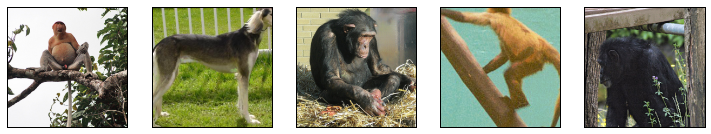

In [99]:
show_image_row([im_new])